# Data science project in Python - Voorspellingen maken met features

Doormiddel van numpy, pandas, matplotlib & SciKit-learn

Door Louis D'Hont - Elektronica-ICT - 2021

Dit project is het tweede deel van het data science project. Bekijk project-deel-1 om het data cleaning proces te zien.

In [1]:
# Importeren van gebruikte bibliotheken
import datetime
import seaborn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import classification_report

from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_classification

## 1 - Features behandelen

### 1.1 - Inlezen features

Onderstaande code leest het *featuresDataFrame* bestand in en zet deze om naar een dataframe. In deel 1 van het project is er nog een aanpassing gebeurd, de kolom *Geboortedatum* werd alsnog meegenomen als feature om hierna verdere berekeningen te kunnen doen.

In [2]:
features = pd.read_csv("featuresDataFrame.csv", sep=',') 
features = features.drop(['Unnamed: 0'], axis=1)

### 1.2 - Omzetten van datatypes

De opgeslagen data is bij het inlezen opnieuw van het type int64, float64 en object. De data dat hiervoor een timedelta was ('Aantal dagen tot vertrek' en de 'Aantal dagen op reis' kolom) moet worden omgezet zodat er terug met kan worden gewerkt.

Elk land werd omgezet in een cijfer. De onderstaande lijst toont de eerste 5 landen met hun corresponderende cijfer.

- 1 België
- 2 Nederland
- 3 Frankrijk
- 4 Duitsland
- 5 Groot Brittannië

Elk reistype werd ook eveneens omgezet in een cijfer. De onderstaande lijst toont de reis types met hun corresponderende cijfer.

- 1 Ruitervakantie
- 2 Ponykamp
- 3 Ruitervakantie& Vliegreis
- 4 Trektocht
- 5 Ruitervakantie Eigen Vervoer
- 6 Huifkar tocht
- 7 Safari
- 8 Jeugdkamp
- 9 Weekendje weg

In [3]:
def convert_timedelta(df_col):
    for index, row in enumerate(df_col): 
        days, timestamp = row.split(" days ")
        df_col.iloc[index] = days
    return df_col

def convert_land(df_land):
    for index, row in enumerate(df_land):
        if row == 'be':
            df_land.iloc[index] = 1
        elif row == 'nl':
            df_land.iloc[index] = 2
        elif row == 'fr':
            df_land.iloc[index] = 3
        elif row == 'de':
            df_land.iloc[index] = 4
        elif row == 'gb':
            df_land.iloc[index] = 5  
        elif row == 'lux':
            df_land.iloc[index] = 6
        elif row == 'sco':
            df_land.iloc[index] = 7
        elif row == 'pt':
            df_land.iloc[index] = 8
        elif row == 'sco':
            df_land.iloc[index] = 9
        elif row == 'sr':
            df_land.iloc[index] = 10
        elif row == 'cn':
            df_land.iloc[index] = 11
        elif row == 'aut':
            df_land.iloc[index] = 12
        elif row == 'ca':
            df_land.iloc[index] = 13   
        elif row == 'it':
            df_land.iloc[index] = 14
        elif row == 'es':
            df_land.iloc[index] = 15
        elif row == 'cl':
            df_land.iloc[index] = 16

def convert_reis_type(df_reistype):
    for index, row in enumerate(df_reistype):
        if row == 'Ruitervakantie':
            df_reistype.iloc[index] = 1
        elif row == 'Ponykamp':
            df_reistype.iloc[index] = 2
        elif row == 'Ruitervakantie& Vliegreis':
            df_reistype.iloc[index] = 3
        elif row == 'Trektocht':
            df_reistype.iloc[index] = 4
        elif row == 'Ruitervakantie Eigen Vervoer':
            df_reistype.iloc[index] = 5  
        elif row == 'Huifkar tocht':
            df_reistype.iloc[index] = 6
        elif row == 'Safari':
            df_reistype.iloc[index] = 7
        elif row == 'Jeugdkamp':
            df_reistype.iloc[index] = 8
        elif row == 'Weekendje weg':
            df_reistype.iloc[index] = 9

features['Datum creatie'] = pd.to_datetime(features['Datum creatie'], format='%Y.%m.%d', infer_datetime_format=True, errors='coerce')
features['Datum vertrek'] = pd.to_datetime(features['Datum vertrek'], format='%Y.%m.%d', infer_datetime_format=True, errors='coerce')
features['Datum terug'] = pd.to_datetime(features['Datum terug'], format='%Y.%m.%d', infer_datetime_format=True, errors='coerce')
    
features['Aantal dagen tot vertrek'] == convert_timedelta(features['Aantal dagen tot vertrek'])
features['Aantal dagen tot vertrek'] = features['Aantal dagen tot vertrek'].astype(int)

features['Aantal dagen op reis'] == convert_timedelta(features['Aantal dagen op reis'])
features['Aantal dagen op reis'] = features['Aantal dagen op reis'].astype(int)
            
features['Land'] == convert_land(features['Land'])
features['Land'] = features['Land'].astype(int)

features['Reistype'] == convert_reis_type(features['Reistype'])
features['Reistype'] = features['Reistype'].astype(int)                                     

/Users/louisdhont/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


### 1.3 - Berekenen leeftijd

De onderstaande code zet de geboortedatum om naar de huidige leeftijd, de lege waarden worden opgevuld met een gemiddelde leeftijd van 40 jaar omdat er kan vanuit worden gegaan dat de gemiddelde persoon 42 jaar is.

In [4]:
features['Geboortedatum'] = pd.to_datetime(features['Geboortedatum'], errors = 'coerce')
features['Leeftijd'] = datetime.datetime.now().year - pd.DatetimeIndex(features['Geboortedatum']).year
features['Leeftijd'] = features['Leeftijd'].fillna(42)
features['Leeftijd'] = features['Leeftijd'].astype(int);

### 1.4 -  Omzetten bestemmingen
    
De bestemmingen data is door het bedrijf manueel ingevoerd. Om de bestemmingen te kunnen koppelen aan een land heb  ik gekozen om elk land om te zetten naar een cijfer. Deze onderstaande lijst toont de eerste 10 landen met hun cijfer. Heel wat reizen bevatten geen directe aanwijzing naar het land maar hebben vaak een bekende stad of streek in de omschrijving, door deze te gaan groeperen konden alle bestemmingen worden omgezet naar hun corresponderende cijfer. Een 20 tal bestemmingen bevatte geen duidelijke aanwijzing naar een land of streek, hiervoor heb ik besloten om deze toe te wijzen aan het land waar de meeste reizen naartoe gaan, met name Frankrijk).

- 1 België
- 2 Nederland
- 3 Frankrijk
- 4 Duitsland
- 5 Portugal
- 6 Ijsland
- 7 Italië
- 8 Ierland
- 9 De Verenigde Staten
- 10 Jordanië

In [5]:
nederland = ['friese', 'nederland', 'vlieland', 'brabant', 'twente', 'drenthe', 'limburg', 'brabantse', 'nederlands', 'duinen', 'salland', 'zeeland', 'ijslanders']
belgie = ['ardennen', 'belgium', 'ardenne', 'belgië', 'belgie', 'arrdennen', 'eifel', 'ardennen', 'ardenen']
frankrijk = ['frankrijk', 'mont saint michel', 'morvan', 'dartmoor', 'couleurs corse', 'vogezen', 'margeride', 'haute valee', 'jura', 'normandië', 'médoc', 'montmorillonnais', 'france', 'loire', 'wijnroute', 'wijngaarden', 'elzas', 'pyreneeën', 'dordogne', 'pyreneeen', 'corsica', 'aude', 'frans', 'armagnac', 'frankrijjk', 'frankijk']
duitsland = ['germany', 'duitsland', 'thuringen', 'beieren', 'duitsand', 'duitse', 'thüringen']
spanje = ['spain', 'spanje', 'sulayr', 'alpujarra', 'middellandse', 'demanda', 'monfrague', 'andalusisch', 'costa brava', 'sierra nevada', 'catalonië','catalonie', 'gredos', 'andalusië', 'ronda', 'andalusie', 'conquistadores']
italie = ['italy', 'italie', 'sicilië', 'madonie', 'italië', 'sardinië', 'sardinie', 'toscane', 'molise', 'alta maremma', 'molise abruzzen']
portugal = ['portugal', 'lusitano', 'faro', 'algarve', 'lissabon', 'portugese', 'azoren']
usa = ['verenigde staten', 'montana', 'usa', 'united states', 'wyoming', 'ranch', 'colorado']
kroatie = ['kroatie', 'croatia', 'kroatië', 'istrië', 'plitvice', 'rode-meer', 'dalmatie', 'istrie']
allerlei = ['Klassieke dressuur van topkwaliteit en stedenschoon', 'Avontuurlijke trektocht door een sprookjesachtig gebied', 'Trektocht in het spoor van de tuimelaar-dolfijn ',
       'Driedaagse trektocht in het land van d\x19Oc en d\x19Oil', 'Trektocht over de bergen naar de zee', 'Trektocht in het spoor van de tuimelaar-dolfijn','Paardrijden langs de route van de bandieten', 'De \x18Great Trek\x19: werkelijk avontuurlijke trektocht',
       'Beach and Bush Rides', 'Dressuurweek','Een week paardrijden met jongvolwassenen','National Park: paardrijden voor pure ontspanning',
       'Driedaagse tocht door de Vienne-vallei','Trektocht naar de gouden stranden', 'Oman','Trektocht tussen zee en woestijnbergen', 'Programma Full','Smokkelaarstocht', 'Trektocht over de bergen naar zee','Beach and Meadows trektocht','De "legendes van de Wolf"-trektocht','Standplaatsvakantie Stertochten', 'nan']

def convert_bestemmingen():
    for index, row in enumerate(features['Bestemming']):
        if any(ext in (str(row).lower()) for ext in belgie):
            features['Bestemming'].iloc[index] = 1
        elif any(ext in (str(row).lower()) for ext in nederland):
            features['Bestemming'].iloc[index] = 2
        elif any(ext in (str(row).lower()) for ext in frankrijk):
            features['Bestemming'].iloc[index] = 3
        elif any(ext in (str(row).lower()) for ext in duitsland):
            features['Bestemming'].iloc[index] = 4
        elif any(ext in (str(row).lower()) for ext in portugal):
            features['Bestemming'].iloc[index] = 5
        elif any(ext in (str(row).lower()) for ext in ['ijsland', 'iceland', 'geysir', 'golden circle']):
            features['Bestemming'].iloc[index] = 6
        elif any(ext in (str(row).lower()) for ext in italie):
            features['Bestemming'].iloc[index] = 7
        elif any(ext in (str(row).lower()) for ext in ['ierland', 'ireland', 'galway', 'ierse', 'donegal']):
            features['Bestemming'].iloc[index] = 8
        elif any(ext in (str(row).lower()) for ext in usa):
            features['Bestemming'].iloc[index] = 9
        elif any(ext in (str(row).lower()) for ext in ['jordanie', 'jordan', 'wadi rum']):
            features['Bestemming'].iloc[index] = 10
        elif any(ext in (str(row).lower()) for ext in spanje):
            features['Bestemming'].iloc[index] = 11
        elif any(ext in (str(row).lower()) for ext in ['botswana']):
            features['Bestemming'].iloc[index] = 12
        elif any(ext in (str(row).lower()) for ext in ['canada', 'yukon', 'alberta', 'saskatchewan']):
            features['Bestemming'].iloc[index] = 13
        elif any(ext in (str(row).lower()) for ext in ['roemenie', 'roemenië', 'transsylvanie', 'transsylvanië']):
            features['Bestemming'].iloc[index] = 14
        elif any(ext in (str(row).lower()) for ext in ['chili', 'chile']):
            features['Bestemming'].iloc[index] = 15
        elif any(ext in (str(row).lower()) for ext in ['marokko', 'marokkaanse', 'berbers']):
            features['Bestemming'].iloc[index] = 16
        elif any(ext in (str(row).lower()) for ext in ['griekenland', 'petra', 'kreta', 'kefalonia']):
            features['Bestemming'].iloc[index] = 17
        elif any(ext in (str(row).lower()) for ext in ['zuid afrika', 'afrika']):
            features['Bestemming'].iloc[index] = 18
        elif any(ext in (str(row).lower()) for ext in ['bulgarije', 'bulgaria', 'balkan']):
            features['Bestemming'].iloc[index] = 19
        elif any(ext in (str(row).lower()) for ext in ['hongarije', 'poesta', 'homgarije']):
            features['Bestemming'].iloc[index] = 20
        elif any(ext in (str(row).lower()) for ext in ['tsjechie', 'tsjechië', 'zuid-bohemen', 'karpaten']):
            features['Bestemming'].iloc[index] = 21   
        elif any(ext in (str(row).lower()) for ext in ['cappadocië', 'turkije', 'turklije', 'thracians']):
            features['Bestemming'].iloc[index] = 22
        elif any(ext in (str(row).lower()) for ext in ['polen', 'poolse', 'poland']):
            features['Bestemming'].iloc[index] = 23
        elif any(ext in (str(row).lower()) for ext in ['namibie', 'namibië']):
            features['Bestemming'].iloc[index] = 24
        elif any(ext in (str(row).lower()) for ext in ['kirgizie', 'kirgizië']):
            features['Bestemming'].iloc[index] = 25
        elif any(ext in (str(row).lower()) for ext in ['montenegro']):
            features['Bestemming'].iloc[index] = 26
        elif any(ext in (str(row).lower()) for ext in ['zweden']):
            features['Bestemming'].iloc[index] = 27
        elif any(ext in (str(row).lower()) for ext in ['albanie', 'albanië', 'katharen']):
            features['Bestemming'].iloc[index] = 28
        elif any(ext in (str(row).lower()) for ext in ['mongolië', 'mongolie', 'mongoolse']):
            features['Bestemming'].iloc[index] = 29
        elif any(ext in (str(row).lower()) for ext in kroatie):
            features['Bestemming'].iloc[index] = 30
        elif any(ext in (str(row).lower()) for ext in ['costa rica']):
            features['Bestemming'].iloc[index] = 31
        elif any(ext in (str(row).lower()) for ext in ['slowakije']):
            features['Bestemming'].iloc[index] = 32
        elif any(ext in (str(row).lower()) for ext in ['brazilie', 'santa catarina gaucho']):
            features['Bestemming'].iloc[index] = 33
        elif any(ext in (str(row).lower()) for ext in ['denemarken', 'denmark', 'deense']):
            features['Bestemming'].iloc[index] = 34
        elif any(ext in (str(row).lower()) for ext in ['noorwegen', 'norway', 'ramsjo-special', 'northern', 'scandinavische']):
            features['Bestemming'].iloc[index] = 35
        elif any(ext in (str(row).lower()) for ext in ['azerbidjan']):
            features['Bestemming'].iloc[index] = 36
        elif any(ext in (str(row).lower()) for ext in ['georgie', 'georgië', 'georgia']):
            features['Bestemming'].iloc[index] = 37
        elif any(ext in (str(row).lower()) for ext in ['zwitserland']):
            features['Bestemming'].iloc[index] = 38
        elif any(ext in (str(row).lower()) for ext in ['groot-brittanie', 'wales', 'britain', 'engeland']):
            features['Bestemming'].iloc[index] = 39
        elif any(ext in (str(row).lower()) for ext in ['argentinie', 'argentinië', 'noord-argentinië']):
            features['Bestemming'].iloc[index] = 40
        elif any(ext in (str(row).lower()) for ext in ['cuba']):
            features['Bestemming'].iloc[index] = 41
        elif any(ext in (str(row).lower()) for ext in ['lapland', 'finland']):
            features['Bestemming'].iloc[index] = 42
        elif any(ext in (str(row).lower()) for ext in ['mexico']):
            features['Bestemming'].iloc[index] = 43
        elif any(ext in (str(row).lower()) for ext in ['china']):
            features['Bestemming'].iloc[index] = 44
        elif any(ext in (str(row).lower()) for ext in ['kenia']):
            features['Bestemming'].iloc[index] = 45
        elif any(ext in (str(row).lower()) for ext in ['iran']):
            features['Bestemming'].iloc[index] = 46
        elif any(ext in (str(row).lower()) for ext in ['servië', 'servie', 'sumadija']):
            features['Bestemming'].iloc[index] = 47
        elif any(ext in (str(row).lower()) for ext in ['schotland']):
            features['Bestemming'].iloc[index] = 48
        elif any(ext in (str(row).lower()) for ext in ['egypte', 'sahara']):
            features['Bestemming'].iloc[index] = 49
        elif any(ext in (str(row).lower()) for ext in ['andorra']):
            features['Bestemming'].iloc[index] = 50
        elif any(ext in (str(row).lower()) for ext in ['uruguay']):
            features['Bestemming'].iloc[index] = 51
        elif any(ext in (str(row).lower()) for ext in ['rusland']):
            features['Bestemming'].iloc[index] = 52
        elif any(ext in (str(row).lower()) for ext in ['columbia', 'colombiaans']):
            features['Bestemming'].iloc[index] = 53
        elif any(ext in (str(row).lower()) for ext in ['australie']):
            features['Bestemming'].iloc[index] = 54
        elif any(ext in str(row) for ext in allerlei):
            features['Bestemming'].iloc[index] = 3
    

features['Bestemming'] == convert_bestemmingen()
features['Bestemming'] = features['Bestemming'].astype(int)


### 1.5 -  Toevoegen categorieën *Vertrek binnen X-X dagen*

De kolommen *Vertrek binnen X-X dagen* bevat steeds een booleanse waarde (True of False) dat aangeeft in welke categorie de reis valt tussen het aantal dagen na het bestellen van een reis en het effectief vertrekken op reis.

In [6]:
features['Vertrek binnen 0-14 dagen'] = (features['Aantal dagen tot vertrek'] <= 14)
features['Vertrek binnen 15-30 dagen'] = ((features['Aantal dagen tot vertrek'] >= 15) & (features['Aantal dagen tot vertrek'] <= 30))
features['Vertrek binnen 31-50 dagen'] = ((features['Aantal dagen tot vertrek'] >= 31) & (features['Aantal dagen tot vertrek'] <= 50))
features['Vertrek binnen 51-100 dagen'] = ((features['Aantal dagen tot vertrek'] >= 50) & (features['Aantal dagen tot vertrek'] <= 100))
features['Vertrek binnen 101-200+ dagen'] = ((features['Aantal dagen tot vertrek'] >= 101))

De onderstaande lijst toont voor elke kolom het datatype. Alle kolommen zijn omgezet naar int, float of datetime. De integer en float waarden kunnen worden gebruikt als feature.

In [7]:
features.dtypes

Status                                    int64
Dossier jaar                              int64
Dossier nr.                               int64
Klantnummer                              object
Datum creatie                    datetime64[ns]
Datum vertrek                    datetime64[ns]
Datum terug                      datetime64[ns]
Totaalprijs                             float64
Betalingen dossier                      float64
Openstaand dossier                      float64
Land                                      int64
Bestemming                                int64
Reistype                                  int64
Aantal reizigers                          int64
Aantal dagen tot vertrek                  int64
Aantal dagen op reis                      int64
Geboortedatum                    datetime64[ns]
Leeftijd                                  int64
Vertrek binnen 0-14 dagen                  bool
Vertrek binnen 15-30 dagen                 bool
Vertrek binnen 31-50 dagen              

### 1.6 - Bekijken van features

In het onderstaande dataframe staan alle gegevens die kunnen worden gebruikt als feature. Het spreekt voor zich dat er uiteraard ook enkele minder relevante zaken zoals klantnummer en datums zullen worden weggelaten uit het finale dataframe waarmee de modellen zullen worden opgebouwd.

In [8]:
features.sample(10)

,Status,Dossier jaar,Dossier nr.,Klantnummer,Datum creatie,Datum vertrek,Datum terug,Totaalprijs,Betalingen dossier,Openstaand dossier,...,Aantal reizigers,Aantal dagen tot vertrek,Aantal dagen op reis,Geboortedatum,Leeftijd,Vertrek binnen 0-14 dagen,Vertrek binnen 15-30 dagen,Vertrek binnen 31-50 dagen,Vertrek binnen 51-100 dagen,Vertrek binnen 101-200+ dagen
2397,1,2017,3108,0659f05462cdc3f5,2017-07-06 00:00:00,2017-08-13,2017-08-20,1203.00,1203.0,0.00,...,1,38,7,NaT,42,False,False,True,False,False
3507,1,2019,20190352,5069f81b40d0d92b,2019-06-21 09:21:26,2019-09-08,2019-11-08,430.00,430.0,0.00,...,2,78,61,1967-11-03,54,False,False,False,True,False
3318,1,2019,20190132,ceec3482ae6cca33,2019-02-23 18:36:54,2019-05-09,2019-09-19,412.48,1175.0,-762.52,...,1,74,133,NaT,42,False,False,False,True,False
2547,1,2017,3275,fd47ed18d7c92d31,2017-02-10 00:00:00,2018-07-07,2018-12-07,3020.00,3020.0,0.00,...,2,512,153,NaT,42,False,False,False,False,True
555,1,2013,1001,a63a9f0281455e8f,2013-05-06 00:00:00,2013-06-07,2013-09-07,1530.00,1530.0,0.00,...,3,32,92,1987-11-27,34,False,False,True,False,False
2455,1,2017,3170,aa6ea32461f13b6a,2017-07-19 00:00:00,2017-07-10,2017-08-10,620.00,620.0,0.00,...,2,9,31,NaT,42,True,False,False,False,False
930,1,2014,1509,54b759dd1977465f,2014-06-30 17:23:06,2014-10-18,2014-10-25,1996.00,1996.0,0.00,...,1,109,7,1951-05-01,70,False,False,False,False,True
541,1,2013,982,a49456962a789a6a,2013-05-23 00:00:00,2013-07-06,2013-06-14,1160.00,1160.0,0.00,...,1,44,22,NaT,42,False,False,True,False,False
2382,1,2017,3090,27ef1c88bf81fa78,2017-07-06 00:00:00,2017-06-16,2017-06-18,275.00,275.0,0.00,...,1,20,2,NaT,42,False,True,False,False,False
3641,1,2019,20190518,0be58378f0d29024,2019-11-13 15:13:16,2021-05-06,2021-12-06,2043.03,700.0,1343.03,...,1,539,214,1937-12-22,84,False,False,False,False,True


# 2 - Evalueren en selecteren van features

Enkele interessante features die in de dataset te vinden zijn:

 - **Status**: De status (1 of 0) heeft aan of de boeking bevestigd of geannuleerd is.
 - **Dossier jaar**: Het jaar waarin het dossier werdt aangemaakt.
 - **Dossier nr.**: Een nummer (id) dat iedere reis identificeert.
 - **Klantnummer**: Het nummer dat een klant identificeert.
 - **Datum creatie**: Deze feature heeft een datum met uur, minuten en seconden. Deze waardes kunnen interessant zijn om te kijken hoeveel tijd er tussen een boeking en de reis vertrek datum zit.
 - **Datum vertrek**: De datum waarop een reis start.
 - **Datum terug**: De datum waarop de reizigers terugkeren naar hun thuisland.
 - **Totaalprijs**: De prijs die ze in totaal betalen voor de reis.
 - **Betalingen dossier**: Het bedrag dat al betaald is.
 - **Openstaand dossier**: Het bedrag dat nog moet betaald worden om te kunnen voldoen en te mogen vertrekken op reis.
 - **Land**: Het thuisland van de reiziger.
 - **Bestemming**: Het land waar de reiziger naartoe geweest is.
 - **Reistype**: Het type reis dat de reiziger neemt.
 - **Aantal reizigers**: Het aantal personen die mee opreis gaan.
 - **Aantal dagen tot vertrek**: Het berekende aantal dagen tussen het aanmaken van een account en de vertrek datum.
 - **Aantal dagen op reis**: Het berekende aantal dagen dat de reis duurde.
 - **Leeftijd**: Leeftijd van de klant.
 - **vertrek binnen x dagen**: Deze 5 features bevatten een booleanse true of false (1 of 0) waarde dat weergeeft in welke categorie van het aantal dagen tot vertrek de klant hoort.
 

### 2.1 - Correlatie tussen features

Onderstaande matrix toont aan hoe de features met elkaar verbonden zijn op een schaal van 0 tot 1. Hoe hoger de score bij 1 ligt hoe dichter de features gecorreleerd zijn met elkaar. De correlatie tussen de eigen data is steeds 1 wat ook wordt weergegeven in de diagonale donkerrode lijn.

In de matrix zien we dat er enkele features een goede correlatie hebben met elkaar (hoger dan 0.4).
Zo zijn het aantal reizigers, de totaal prijs en het dossier nummer en jaar best interessante features. Omdat er enkele features (dossier nummer en jaar & Totaalprijs en Betalingen Dossier) een hoge correlatie hebben kan dit zorgen voor overfitting, hierdoor is het best om één van de twee waarden niet op te nemen als feature in het model. Bij het splitten van de train en test data zullen de kolommen 'Dossier nr.' en 'Betalingen Dossier' weggelaten worden.

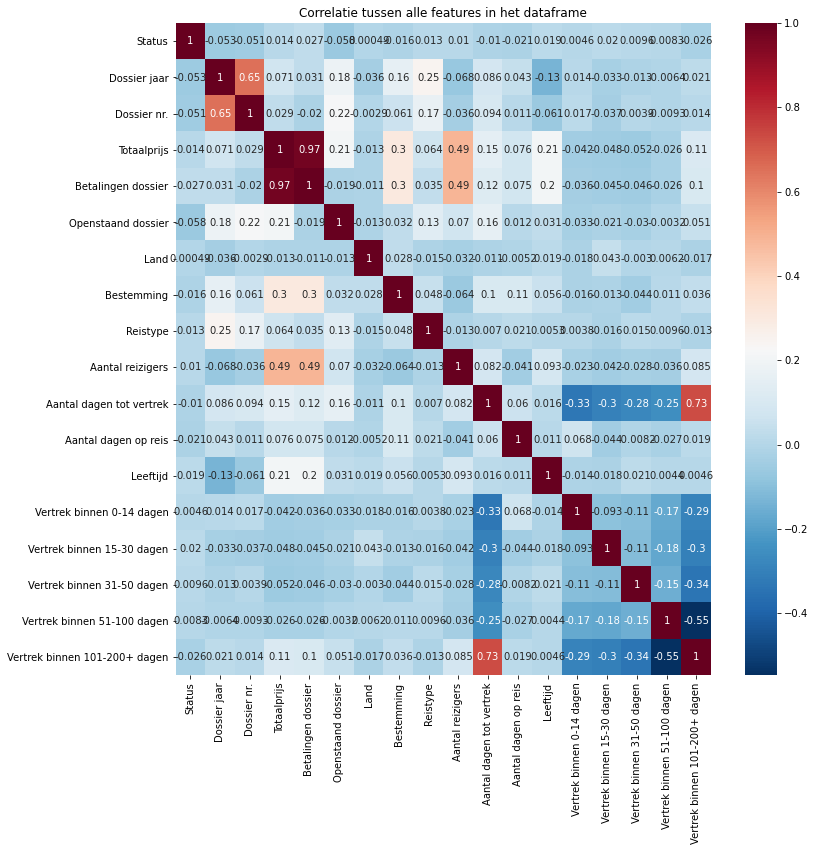

In [9]:
plt.figure(figsize=(12, 12))
plt.title('Correlatie tussen alle features in het dataframe')
seaborn.heatmap((features).corr(), annot=True, cmap="RdBu_r")
plt.show();

### 2.2 - Opsplitsen van train en test data

Onderstaande code splitst de data op in train en test data. In dit geval wordt de data opgesplitst volgens de standaard 75% train data en 25% test data. De niet numerieke kolommen worden uit de dataset weggelaten en de target wordt ingesteld in de 'y' array. Om de data te schalen maak ik gebruik van de StandardScaler. Het idee hierachter is dat het de gegevens zodanig zal transformeren dat de distributie een gemiddelde waarde van 0 en een standaardafwijking van 1 heeft.

Bij Multivariate data gebeurt dit feature-wise (dus onafhankelijk voor elke kolom van de data).
Gezien de verdeling van de gegevens, wordt bij elke waarde in de gegevensset de gemiddelde waarde afgetrokken en vervolgens gedeeld door de standaarddeviatie van de hele gegevensset (of kenmerk in het multivariate geval).

De volgende kolommen worden verwijderd uit het features dataframe:
 - **Klantnummer** Een klantnummer is geen numerieke waarde dus dit kan niet meegeven worden aan modellen.
 - **Geboortedatum** De kolom met geboortedatums is geen numerieke waarde en de leeftijd is hieruit berekend dat wel als feature kan dienen.
 - **Dossier nr.** De kolom met de dossier nummers had een hoge correlatie met het dossier jaar waardoor het interessant is om deze niet mee op te nemen in de features lijst, dit kan het model ten goede komen omdat er overfitting kan ontstaan met hoog gecorreleerde features onderling.
 - **Betalingen dossier** Het bedrag dat al reeds betaald was is ook hoog gecorreleerd met het totaal bedrag waardoor deze kolom ook kan worden weggelaten uit de features.
 - **Datums** De kolommen *Datum creatie*, *Datum vertrek* en *Datum terug* zijn datums die al gebruikt zijn om zaken te berekenen (Aantal dagen op reis en Aantal dagen tot vertrek).

In [10]:
def scale_data(df):
    X = df.drop(['Aantal dagen tot vertrek', 'Klantnummer', 'Openstaand dossier', 'Totaalprijs', 'Geboortedatum', 'Dossier nr.', 'Betalingen dossier',  'Datum creatie', 'Datum vertrek', 'Datum terug'], axis=1)
    y = df['Aantal dagen tot vertrek']
    featureNames = X.columns
    scaler = StandardScaler()
    scaler.fit(X)
    return scaler.transform(X), y, featureNames

X, y, featureNames = scale_data(features)
# split voor KNN en al de rest + maak functie van bovenstaande code
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

De geschaalde data in het dataframe *X*.

In [11]:
X

array([[  0.06367683,  -2.09338933,   0.33372771, ...,  -0.3511898 ,
         -0.56744044,   1.03598266],
       [  0.06367683,  -2.09338933,   0.33372771, ...,  -0.3511898 ,
         -0.56744044,   1.03598266],
       [  0.06367683,  -2.09338933,   0.33372771, ...,  -0.3511898 ,
         -0.56744044,   1.03598266],
       ...,
       [  0.06367683,   1.98790608,   0.33372771, ...,  -0.3511898 ,
          1.76229949,  -0.96526712],
       [-15.70429877,   1.98790608,   0.33372771, ...,  -0.3511898 ,
         -0.56744044,   1.03598266],
       [  0.06367683,   1.98790608,   0.33372771, ...,  -0.3511898 ,
          1.76229949,  -0.96526712]])

De vorm van de *X* en *y* array wordt hieronder afgeprint. De *X* dataset bevat 10 features (kolommen) en 3962 rijen, de *y* array bevat de target data met 1 kolom en 3962 rijen aan data. Het aantal rijen en features van de trainings- en testset worden ook weergegeven. De trainingsset bedraagt 2971 rijen aan data en de testset 991 rijen.

In [12]:
print("Shape van de X data:", X.shape)
print("Shape van de y target data:", y.shape)

Shape van de X data: (3962, 13)
Shape van de y target data: (3962,)


In [13]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print("Aantal features:", X.shape[1])

X_train shape: (2971, 13)
y_train shape: (2971,)
X_test shape: (991, 13)
y_test shape: (991,)
Aantal features: 13


# 3 - Modellen evalueren, vergelijken en testen

In de volgende stappen worden enkele modellen getest om te zien hoe de modellen het doen op de train en test data.

### KNN

KNN is het eenvoudigste model dat we gaan uittesten. Het onthoudt de trainingsgegevens en plaatst de te voorspellen gegevens in dezelfde grafiek. Om elk doel te voorspellen, zoekt het KNN-model het dichtstbijzijnde punt in de trainingsdata en stelt de waarde van het te voorspellen gegeven in op dat van de dichtstbijzijnde buur. Er kan ingesteld worden hoeveel buren het model moet gebruiken om een waarde aan het doel te geven. Meer of minder buren kiezen kan een goede of slechte invloed hebben op het classificerings model.

### Decision tree

Een decision tree is een algoritme dat gebruikmaakt van een boomachtig model om beslissingen te maken en hun mogelijke gevolgen te gaan afwegen. Het is een algoritme dat alleen voorwaardelijke controle-instructies bevat en op basis daarvan tot een voorspelling komt.

Decision trees hebben 2 hoofdzakelijke types:

* Classification tree is wanneer de voorspelde uitkomst de klasse is waartoe de gegevens behoren.
* Regression is wanneer de voorspelde uitkomst als een reëel getal kan worden beschouwd (bijvoorbeeld de prijs van een huis of de leeftijd van een persoon).

### Logistic regression

Logistic regression is een statistische methode voor het voorspellen van binaire klassen. De uitkomst- of doelvariabele is dichotoom van aard. Dichotoom betekent dat er maar twee mogelijke klassen zijn (binair). Het is een speciaal geval van lineaire regressie waarbij de doelvariabele categorisch van aard is. Logistische regressie voorspelt de waarschijnlijkheid van optreden van een binaire gebeurtenis met behulp van een logitfunctie.

### Random Forest tree

Random forest is een verzameling van decision trees. Het Random Forest algoritme werkt volgens de *bootstrap aggregating* (bagging) techniek, hierbij worden door middel van trekkingen een aantal sub-datasets uit de data genomen, op basis waarvan worden decision trees opgesteld. De predictie voor een nieuwe observatie wordt vervolgens bepaald door het gemiddelde van de predicties van de verschillende decision trees te nemen. Omdat de decision trees veel op elkaar kunnen lijken en één of een beperkt aantal verklarende variabelen dominant kunnen zijn, wordt er bij iedere splitsing een subset van de verklarende variabelen gebruikt op basis van enkele trekking.

Het Random Forest algoritme heeft als voordeel dat het met grote hoeveelheden data te omgaan.

## Testen van verschillende modellen

## 3.1 - KNN-model

Onderstaande code print voor elke iteratie de train en test score uit met 4 grafieken. De twee linkse grafieken tonen het percentage per aantal neighbors op de hele trainingsset. De twee rechtse grafieken tonen het percentage per aantal neighbors op de testdata. Hieruit blijkt dat op de trainingsdata het slaagpercentage afzwakt naarmate er meer neighbors bijkomen. Wat opvalt is dat bij 1 en 2 neightbors bij de trainingsset tegenover de testset er duidelijk overfitting optreedt.

Ik gebruik de Elbow methode om de beste waarde voor k (aantal neightbors) te vinden, deze waarde is dan af te lezen van de grafiek en wordt uitgeprint voor iedere iteratie met de bijhorende train en test scores. In mijn opstelling zal deze later ingesteld worden op 3, nadien doen we voor de evaluatie van het model nogmaals dezelfde stappen maar deze keer met een niet variabele k.

Tijdens het uittesten van het KNN-model viel me op dat het schalen van de data met de StandardScaler een positief maar kleine verbetering gaf in de train- en testdata.

Iteratie: 1
Accuracy on training set: 0.927
Accuracy on test set: 0.076
*-------------------------------*
Iteratie: 2
Accuracy on training set: 0.531
Accuracy on test set: 0.064
*-------------------------------*
Iteratie: 3
Accuracy on training set: 0.386
Accuracy on test set: 0.059
*-------------------------------*
Iteratie: 4
Accuracy on training set: 0.312
Accuracy on test set: 0.059
*-------------------------------*
Iteratie: 5
Accuracy on training set: 0.275
Accuracy on test set: 0.058
*-------------------------------*
Iteratie: 6
Accuracy on training set: 0.248
Accuracy on test set: 0.055
*-------------------------------*
Iteratie: 7
Accuracy on training set: 0.227
Accuracy on test set: 0.052
*-------------------------------*
Iteratie: 8
Accuracy on training set: 0.218
Accuracy on test set: 0.058
*-------------------------------*
Iteratie: 9
Accuracy on training set: 0.204
Accuracy on test set: 0.058
*-------------------------------*
Iteratie: 10
Accuracy on training set: 0.194
A

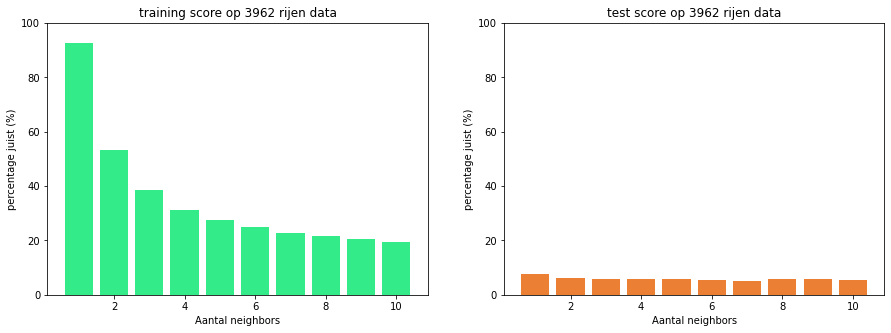

In [14]:
trainingScoreKNN = []
testScoreKNN = []
neighbors = 10

for k in range(1, neighbors + 1):
    knn = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)
    
    trainingScoreKNN.append(round(knn.score(X_train, y_train) * 100, 2))
    testScoreKNN.append(round(knn.score(X_test, y_test) * 100, 2))
    
    print("Iteratie: " + str(k))
    print("Accuracy on training set: {:.3f}".format(knn.score(X_train, y_train)))
    print("Accuracy on test set: {:.3f}".format(knn.score(X_test, y_test)))
    print("*-------------------------------*")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
objects = range(1, neighbors + 1)

ax1.bar(objects, trainingScoreKNN, align='center', color = "#34eb89")
ax1.set_ylim(0, 100)
ax1.set_title('training score op ' + str(len(X)) + ' rijen data')
ax1.set_ylabel('percentage juist (%)')
ax1.set_xlabel('Aantal neighbors')

ax2.bar(objects, testScoreKNN, align='center', color = "#eb8034")
ax2.set_ylim(0, 100)
ax2.set_title('test score op ' + str(len(X)) + ' rijen data')
ax2.set_ylabel('percentage juist (%)')
ax2.set_xlabel('Aantal neighbors')
plt.show();

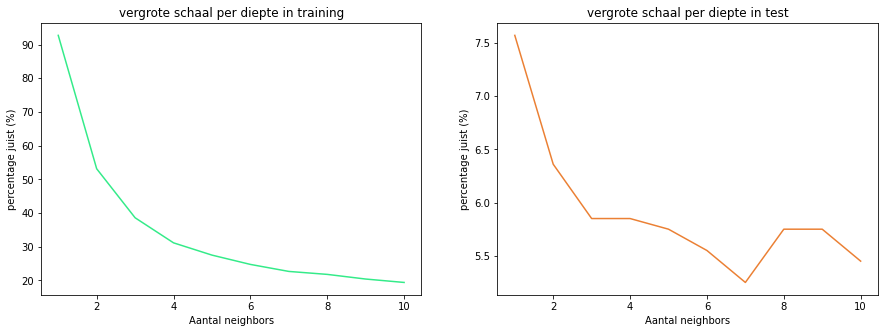

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(objects, trainingScoreKNN, color = "#34eb89")
ax1.set_title('vergrote schaal per diepte in training')
ax1.set_ylabel('percentage juist (%)')
ax1.set_xlabel('Aantal neighbors')

ax2.plot(objects, testScoreKNN, color = "#eb8034")
ax2.set_title('vergrote schaal per diepte in test')
ax2.set_ylabel('percentage juist (%)')
ax2.set_xlabel('Aantal neighbors');

### 3.1.1 - Finaal KNN-model met vaste waarde

We zien hieronder een duidelijke overfitting optreden (een beter prestatie van het model op de trainingsset als op de testset). De k waarde is zo optimaal mogelijk gekozen maar omdat het een relatief kleine dataset is wordt het moeilijker om een goede voorspelling te doen en is de testscore zeer laag. Hoe hoger het aantal neightbors (k) hoe slechter de trainingsset zal scoren, de testset zakt eveneens mee omlaag. Bij 1 neightbor is de trainingsscore zeer hoog, door overfitting blijft de testscore ook zeer laag (+/- 5%).

In [16]:
knn = KNeighborsClassifier(n_neighbors = 1)
knn.fit(X_train, y_train)
pred = knn.predict(X_test)
trainingScore = round(knn.score(X_train, y_train), 2)
testScore = round(knn.score(X_test, y_test), 2)

print("Training set score: " + str(trainingScore))
print("Test set score: " + str(testScore))

Training set score: 0.93
Test set score: 0.08


## 3.2 - Decision tree classifier model

Onderstaande code print voor elke iteratie de train en test score uit met 4 grafieken. De twee linkse grafieken tonen het percentage voor elke diepte op de hele trainingsset. De twee rechtse grafieken tonen het percentage van de testdata voor elke diepte. Hieruit blijkt dat op de trainingsdata het slaagpercentage toeneemt bij een hogere diepte, dit blijft doorgaan tot een diepte van 40, hierna vlakt de score af tot 85% en wordt deze niet beter. Het is uiteraard ook niet goed om een te hoge diepte in te stellen omdat er dan te veel opsplitsingen gebeuren en zo het model te specifiek wordt getrained op de aangeleverde dataset. Het Decision tree algoritme is ook heel wat sneller dan het KNN classifier model.

De 2 onderste grafieken geven een ingezoomde lijn grafiek weer om het verloop tussen beter zichtbaar te maken.

Iteratie: 1
Accuracy on training set: 0.018
Accuracy on test set: 0.015
*-------------------------------*
Iteratie: 2
Accuracy on training set: 0.029
Accuracy on test set: 0.023
*-------------------------------*
Iteratie: 3
Accuracy on training set: 0.039
Accuracy on test set: 0.026
*-------------------------------*
Iteratie: 4
Accuracy on training set: 0.054
Accuracy on test set: 0.037
*-------------------------------*
Iteratie: 5
Accuracy on training set: 0.064
Accuracy on test set: 0.040
*-------------------------------*
Iteratie: 6
Accuracy on training set: 0.076
Accuracy on test set: 0.045
*-------------------------------*
Iteratie: 7
Accuracy on training set: 0.095
Accuracy on test set: 0.048
*-------------------------------*
Iteratie: 8
Accuracy on training set: 0.119
Accuracy on test set: 0.047
*-------------------------------*
Iteratie: 9
Accuracy on training set: 0.150
Accuracy on test set: 0.051
*-------------------------------*
Iteratie: 10
Accuracy on training set: 0.182
A

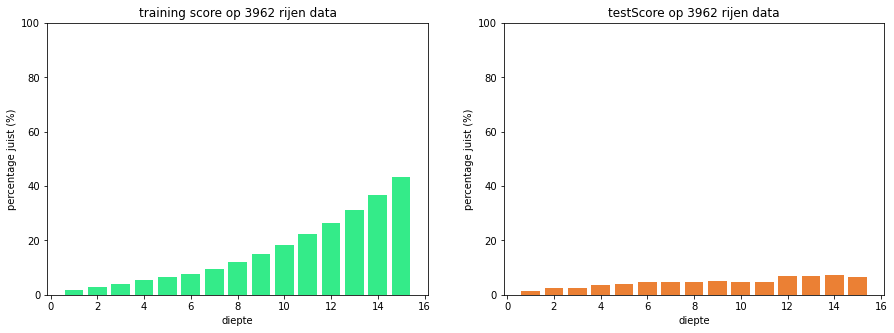

In [17]:
trainingScoreDec = []
testScoreDec = []
depth = 15

for n in range(1, depth + 1):
    treeModel = DecisionTreeClassifier(max_depth=n, random_state=42).fit(X_train, y_train)
    
    trainingScoreDec.append(round(treeModel.score(X_train, y_train) * 100, 2))
    testScoreDec.append(round(treeModel.score(X_test, y_test) * 100, 2))
    print("Iteratie: " + str(n))
    print("Accuracy on training set: {:.3f}".format(treeModel.score(X_train, y_train)))
    print("Accuracy on test set: {:.3f}".format(treeModel.score(X_test, y_test)))
    print("*-------------------------------*")
    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
objects = range(1, depth + 1)

ax1.bar(objects, trainingScoreDec, align='center', color = "#34eb89")
ax1.set_ylim(0, 100)
ax1.set_title('training score op ' + str(len(X)) + ' rijen data')
ax1.set_ylabel('percentage juist (%)')
ax1.set_xlabel('diepte')

ax2.bar(objects, testScoreDec, align='center', color = "#eb8034")
ax2.set_ylim(0, 100)
ax2.set_title('testScore op ' + str(len(X)) + ' rijen data')
ax2.set_ylabel('percentage juist (%)')
ax2.set_xlabel('diepte');

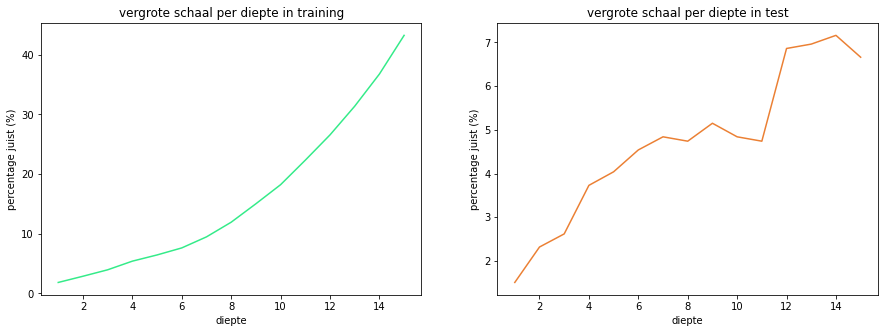

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(objects, trainingScoreDec, color = "#34eb89")
ax1.set_title('vergrote schaal per diepte in training')
ax1.set_ylabel('percentage juist (%)')
ax1.set_xlabel('diepte')

ax2.plot(objects, testScoreDec, color = "#eb8034")
ax2.set_title('vergrote schaal per diepte in test')
ax2.set_ylabel('percentage juist (%)')
ax2.set_xlabel('diepte');

### 3.2.1 - Finaal Decision tree model

We zien hieronder terug een duidelijke overfitting optreden (een beter prestatie van het model op de trainingsset als op de testset). De decision tree is bij een hoge diepte acurater maar het bljft slecht scoren op de testset. Overfitting blijft steeds optreden, in de grafieken hierboven zagen we ook dat de test scores zeer weinig stegen tegenover de trainings scores.

In [19]:
trainingScore = []
testScore = []

treeModel = DecisionTreeClassifier(max_depth=15, random_state=42).fit(X_train, y_train)
trainingScore = round(treeModel.score(X_train, y_train), 2)
testScore = round(treeModel.score(X_test, y_test), 2)

print("Cross validation score: " + str(cross_val_score(treeModel, X_train, y_train, cv=5)))
print("Training set score: " + str(trainingScore))
print("Test set score: " + str(testScore))

Cross validation score: [0.05378151 0.05723906 0.07407407 0.06397306 0.07407407]
Training set score: 0.43
Test set score: 0.07


/Users/louisdhont/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


## 3.3 - Logistic regression

Logistic regression is een lineair model voor classificatie. Het gebruikte algoritme heet *Solver*. De solver is ingesteld op *liblinear* aangezien dit een multiclass dataset kan verwerken en dit gebaseerd is op kansverhoudingen. De verhouding tussen de fracties bij twee mogelijke uitkomsten wordt hierin bepaald en zo geclassificeerd. Dit principe wordt uitgevoerd en vervolgens herhaald indien het in de rest thuishoort (een soort van binaire classificatie).

De score is in beide gevallen zeer laag op de tranings- en testset omdat dit een binair clasificatie methode is. Hierdoor is het dus een algoritme dat niet kan worden gebruikt in dit project.

In [20]:
trainingScore = []
testScore = []

logRegr = LogisticRegression(solver='liblinear', max_iter=500, multi_class = 'auto').fit(X_train, y_train)
trainingScore.append(round(logRegr.score(X_train, y_train) * 100, 2))
testScore.append(round(logRegr.score(X_test, y_test) * 100, 2))

print("Accuracy on training set: {:.3f}".format(logRegr.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(logRegr.score(X_test, y_test)))

Accuracy on training set: 0.114
Accuracy on test set: 0.050


## 3.4 - Random forest tree

.....

In [21]:
forest = RandomForestClassifier(n_estimators=100, random_state=42)
forest.fit(X_train, np.ravel(y_train, order='C'))

y_predForest = forest.predict(X_test)

print("Accuracy on training set: {:.3f}".format(forest.score(X_train, y_train), 2))
print("Accuracy on test set: {:.3f}".format(forest.score(X_test, y_test), 2))

Accuracy on training set: 0.930
Accuracy on test set: 0.104


# 4 - Eerste evaluatie



Uitleg?


# 5 - Bijstellen van features

## 5.1 - KNN error evaluatie



/Users/louisdhont/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"
/Users/louisdhont/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"
/Users/louisdhont/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"
/Users/louisdhont/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has o

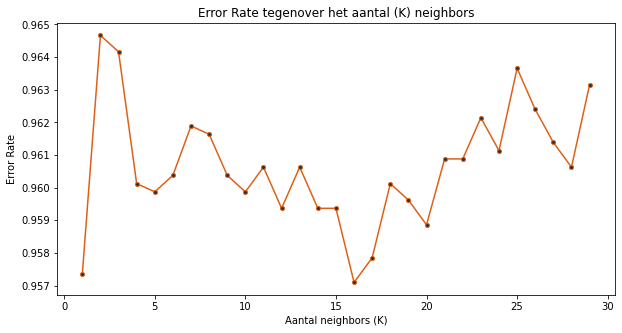

In [22]:
err_knn_val = [] 
neighbors = 30

for k in range(1, neighbors):
    knn = KNeighborsClassifier(n_neighbors = k)
    scores = cross_val_score(knn, X, y, cv = 3)                                                         
    error = 1 - scores.mean()
    err_knn_val.append(error)

plt.figure(figsize=(10, 5))
plt.plot(range(1, neighbors), err_knn_val, color="#de5f16", marker="o", markerfacecolor="#303030", markersize=4)
plt.title("Error Rate tegenover het aantal (K) neighbors")
plt.xlabel("Aantal neighbors (K)")
plt.ylabel("Error Rate")
plt.show();

## 5.2 - cross-validation

Cross validatie is een techniek om te beschermen tegen overfitting in een model. Bij cross validatie wordt er een vast aantal folds (of partities) van de gegevens genomen, daarna wordt de analyse uitgevoerd op elke fold en een gemiddelde van de totale foutschatting berekend.

Deze techniek wordt hieronder uitgevoerd met KNN (k-nearest neighbors), Linaire regressie en Decision tree.

### 5.2.1 - Cross validation met KNN

In [23]:
kFold = KFold(n_splits=10, shuffle=True, random_state=42)

KNN = KNeighborsClassifier(n_neighbors = 5).fit(X_train, y_train)

df_knn = pd.DataFrame(cross_validate(KNN, X, y, cv=kFold, return_train_score=True))
scores = cross_val_score(KNN, X, y, cv = 2)

print("Cross-validation scores: {}".format(scores))
print("Average cross-validation score: {:.2f}".format(scores.mean()))
df_knn

/Users/louisdhont/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Cross-validation scores: [0.04088844 0.03584048]
Average cross-validation score: 0.04


,fit_time,score_time,test_score,train_score
0,0.010516,0.034845,0.073048,0.271529
1,0.008578,0.024802,0.065491,0.276297
2,0.008255,0.024666,0.037879,0.279305
3,0.011029,0.032405,0.063131,0.281268
4,0.012496,0.034886,0.060606,0.275098
5,0.011450,0.032931,0.055556,0.273696
6,0.011289,0.034172,0.098485,0.265844
7,0.008763,0.028179,0.047980,0.277342
8,0.010998,0.031399,0.060606,0.279024
9,0.010555,0.034236,0.035354,0.280987


### 5.2.2 - Cross validation met linear regression

In [24]:
linair = LinearRegression().fit(X_train, y_train)

df_lin = pd.DataFrame(cross_validate(linair, X, y, cv=kFold, return_train_score=True))
scores = cross_val_score(linair, X, y)

print("Average cross-validation score: {:.2f}".format(scores.mean()))
df_lin

Average cross-validation score: 0.60


,fit_time,score_time,test_score,train_score
0,0.002371,0.000716,0.536517,0.591009
1,0.001551,0.000506,0.570013,0.587342
2,0.002084,0.000462,0.534012,0.591794
3,0.001425,0.000399,0.612974,0.582483
4,0.001427,0.000582,0.584924,0.585624
5,0.001726,0.000408,0.607880,0.582937
6,0.001425,0.000541,0.566156,0.587628
7,0.001602,0.000510,0.645749,0.579202
8,0.002707,0.000721,0.596394,0.584273
9,0.001665,0.000513,0.587119,0.585236


### 5.2.3 - Cross validation met decision tree

In [25]:
decTree = DecisionTreeClassifier(max_depth=5, random_state=42).fit(X_train, y_train)

df_dec = pd.DataFrame(cross_validate(decTree, X, y, cv=kFold, return_train_score=True))
scores = cross_val_score(decTree, X, y)

print("Average cross-validation score: {:.2f}".format(scores.mean()))
df_dec

Average cross-validation score: 0.04


/Users/louisdhont/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


,fit_time,score_time,test_score,train_score
0,0.008351,0.001613,0.037783,0.063114
1,0.007536,0.001328,0.040302,0.062553
2,0.007536,0.000726,0.037879,0.060572
3,0.006123,0.000552,0.042929,0.057487
4,0.005625,0.000572,0.040404,0.062815
5,0.005691,0.000554,0.032828,0.067022
6,0.005640,0.000541,0.030303,0.061974
7,0.005505,0.000618,0.040404,0.063376
8,0.005548,0.000515,0.022727,0.061413
9,0.005543,0.000525,0.055556,0.059450


## 5.3 - Grid Search

Below we divide the data into a test-set, training-set and a validation set. These will be used to figure out which is the best model. After these steps, we use grid search to better the model.

Splitten van data + validatie set

In [26]:
X_train_validation, X_test, y_train_validation, y_test = train_test_split(X, y, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_validation, y_train_validation, random_state=42)

print("Grootte van training set: {} , Grootte van validation set: {}, Grootte van test set:"" {}\n".format(X_train.shape[0], X_valid.shape[0], X_test.shape[0]))

Grootte van training set: 2228 , Grootte van validation set: 743, Grootte van test set: 991



### 5.3.1 - Grid Search in KNN

Uitleg zoeken van beste KNN K en model in variabele plaatsen en uitprinten van scores voor dat gekozen model.


In [27]:
beste_score = 0
beste_parameters = 0
top_score = 0
beste_model = 0
neighbors = 10

for k in range(1, neighbors + 1):
    KNN = KNeighborsClassifier(n_neighbors = k).fit(X_train, y_train)
    score = KNN.score(X_valid, y_valid)
    
    if score > beste_score:
        beste_parameters = {'n_neighbors': k}
        beste_score = score
        if score > top_score:
            beste_model = knn
            top_score = score

knn = KNeighborsClassifier(**beste_parameters).fit(X_train_validation, y_train_validation)
training_score = knn.score(X_train, y_train)
test_score = knn.score(X_test, y_test)

print("Beste parameters:", beste_parameters)
print("")
print("Trainingsset score met de beste gekozen parameters: {:.2f}".format(training_score))
print("Beste score op de validatie set: {:.2f}".format(beste_score))
print("Test set score met de best gekozen parameters: {:.2f}".format(test_score))

Beste parameters: {'n_neighbors': 1}

Trainingsset score met de beste gekozen parameters : 0.92
Beste score op de validatie set: 0.06
Test set score met de best gekozen parameters: 0.09


### 5.3.2 - Grid Search in Decision tree

In [28]:
beste_score = 0
max_depth = 15

for depth in range(1, max_depth + 1):
    for random_st in [0, 5, 10, 20, 40]:
        tree = DecisionTreeClassifier(max_depth=depth, random_state=random_st)
        tree.fit(X_train, y_train)
        score = tree.score(X_valid, y_valid)
        
        if score > beste_score:
            beste_parameters = {'max_depth': depth, 'random_state': random_st}
            beste_score = score
            if score > top_score:
                best_model = tree
                top_score = score

tree = DecisionTreeClassifier(**beste_parameters)
tree.fit(X_train_validation, y_train_validation)
training_score = tree.score(X_train, y_train)
test_score = tree.score(X_test, y_test)

print("Beste parameters:", beste_parameters)
print("")
print("Training set score with best parameters: {:.2f}".format(training_score))
print("Beste score op de validatie set: {:.2f}".format(beste_score))
print("Test set score met de best gekozen parameters: {:.2f}".format(test_score))

Beste parameters: {'max_depth': 15, 'random_state': 40}

Training set score with best parameters: 0.40
Beste score op de validatie set: 0.06
Test set score met de best gekozen parameters: 0.06


### 5.3.3 - Grid Search met Random forest tree

n_estimators = aantal trees
random_state = bepaalde de randomness
max_depth = maximale tree diepte

random forest duurt altijd lang door.. ?

In [29]:
beste_score = 0
max_estimators = 50

for n in range(1, max_estimators):
    for random_st in [0, 5, 10, 20, 40]:
        rfc = RandomForestClassifier(n_estimators=n, random_state=random_st).fit(X_train, y_train)
        score = rfc.score(X_valid, y_valid)

        if score > beste_score:
            beste_parameters = {'n_estimators': n, 'random_state':random_st}
            beste_score = score
            if score > top_score:
                beste_model = rfc
                topScore = score

rfc = RandomForestClassifier(**beste_parameters).fit(X_train_validation, y_train_validation)
training_score = rfc.score(X_train, y_train)
test_score = rfc.score(X_test, y_test)

print("Beste parameters:", beste_parameters)
print("")
print("Training set score with best parameters: {:.2f}".format(training_score))
print("Beste score op de validatie set: {:.2f}".format(beste_score))
print("Test set score met de best gekozen parameters: {:.2f}".format(test_score))

Beste parameters: {'n_estimators': 42, 'random_state': 5}

Training set score with best parameters: 0.93
Beste score op de validatie set: 0.09
Test set score met de best gekozen parameters: 0.09


## 5.4 - Grid Search in combinatie met Cross-validation

decision tree en random forest

### 5.4.1 - Grid Search en Cross-validation met Decision tree

In [30]:
param_grid = {'max_depth': [1,2,3,4,5], 'random_state': [0,5,10,20,40]}
print("Parameter grid:\n{}".format(param_grid))

grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, return_train_score=True)
grid_search.fit(X_train, y_train)

print("Test set score: {:.2f}".format(grid_search.score(X_test, y_test)))
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
print("Best estimator: {}".format(grid_search.best_estimator_))

Parameter grid:
{'max_depth': [1, 2, 3, 4, 5], 'random_state': [0, 5, 10, 20, 40]}


/Users/louisdhont/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


Test set score: 0.03
Best parameters: {'max_depth': 4, 'random_state': 0}
Best cross-validation score: 0.04
Best estimator: DecisionTreeClassifier(max_depth=4, random_state=0)


### 5.4.2 - Grid Search en Cross-validation met Random forest

In [31]:
param_grid = {'max_depth': [11, 12, 13], 'random_state': [35, 40, 50], 'n_estimators': [75, 100, 125]}

gridSearchTrees = GridSearchCV(RandomForestClassifier(), param_grid, cv=5,return_train_score=True)

# do not overfit the parameters !
gridSearchTrees.fit(X_train, y_train)
pred = gridSearchTrees.predict(X_test)
trainingScoreTrees = round(gridSearchTrees.score(X_train, y_train), 2)
testScoreTrees = round(gridSearchTrees.score(X_test, y_test), 2)

print("Training set score: " + str(trainingScoreTrees))
print("Test set score: " + str(testScoreTrees))
print("Best parameters: {}".format(gridSearchTrees.best_params_))
print("Best cross-validation score: {:.2f}".format(gridSearchTrees.best_score_))

/Users/louisdhont/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


Training set score: 0.87
Test set score: 0.08
Best parameters: {'max_depth': 13, 'n_estimators': 125, 'random_state': 50}
Best cross-validation score: 0.08


## 5.5 - Feature importance

Aantonen hoe belangrijk bepaalde features zijn.

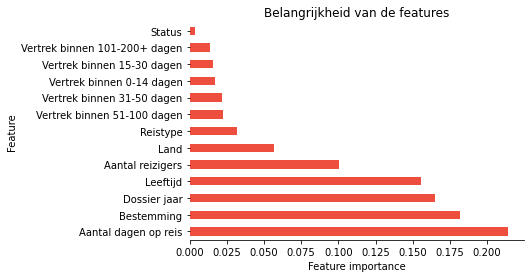

In [32]:
importance = gridSearchTrees.best_estimator_.feature_importances_

dfFeatureImp = pd.DataFrame(importance, index=featureNames, columns=['feature importance']).sort_values('feature importance', ascending=False)
bar = dfFeatureImp.plot(kind='barh', color = "#ED4E3E", legend = None)

plt.xlabel("Feature importance")
plt.ylabel("Feature")
plt.title("Belangrijkheid van de features")
bar.spines['top'].set_visible(False)
bar.spines['right'].set_visible(False)
bar.spines['left'].set_visible(False)
plt.show();

# 6 - Beste gekozen model

Uitleg welk en zo...


In [33]:
training_score = beste_model.score(X_train, y_train)
test_score = beste_model.score(X_test, y_test)
pred_model = best_model.predict(X_test)

print("beste gekozen model met properties:", best_model)
print("")
print("Training set score with best parameters : {:.2f}".format(training_score))
print("Best score on validation set: {:.2f}".format(beste_score))
print("Test set score with best parameters: {:.2f}".format(test_score))
print("Confusion matrix Random dummy :\n{}".format(confusion_matrix(y_test, pred_model)))

beste gekozen model met properties: DecisionTreeClassifier(max_depth=15, random_state=40)

Training set score with best parameters : 0.94
Best score on validation set: 0.09
Test set score with best parameters: 0.09
Confusion matrix Random dummy :
[[1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


## 6.1 - Conclusie

Te weinig goede features die een duidelijk verband hebben met het aantal dagen tot vertrek van een reis

Tijdens het testen van de modellen met en zonder de *Vertrek binnen X-X dagen* features kon ik een klein verschil zien in toename van de testscores.